In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

In [3]:
#load Boolean arrays from intitial hand labelling (iteration 0)
antelope_pospix_iter0 = np.load('/home/esther/poppy-finder/data/antelope_pospix_iter0.npy')
antelope_negpix_iter0 = np.load('/home/esther/poppy-finder/data/antelope_negpix_iter0.npy')
elsinore_pospix_iter0 = np.load('/home/esther/poppy-finder/data/elsinore_pospix_iter0.npy')
elsinore_negpix_iter0 = np.load('/home/esther/poppy-finder/data/elsinore_negpix_iter0.npy')
grassmtn_pospix_iter0 = np.load('/home/esther/poppy-finder/data/grassmtn_pospix_iter0.npy')
grassmtn_negpix_iter0 = np.load('/home/esther/poppy-finder/data/grassmtn_negpix_iter0.npy')

#load files (for visual checks of predictions)
antelope_pos = np.load('/home/esther/shared/2019-03-30_antelope.npy')
antelope_neg = np.load('/home/esther/shared/2019-03-10_antelope.npy')
elsinore_pos = np.load('/home/esther/shared/2019-03-25_elsinore.npy')
elsinore_neg = np.load('/home/esther/shared/2019-04-24_elsinore.npy')
grassmtn_pos = np.load('/home/esther/shared/2019-03-18_grassmtn.npy')
grassmtn_neg = np.load('/home/esther/shared/2019-04-27_grassmtn.npy')

In [4]:
#pulls labelled pixels out of array and formats for input to model

def get_pixdata(pix_bool, img):
    
    #get row and column indices of pixels that have poppies
    idx_row, idx_col = np.nonzero(pix_bool)

    #preallocate array to store pixel data
    pix_data = np.random.random((len(idx_row),13))

    #pull out all 13 channels for each pixel and put into array
    for i, (row, col) in enumerate(zip(idx_row, idx_col)):
        pix_data[i, :] = img[row, col, :]
    #(not the best or most efficient way of doing this but works for now)
        
    return pix_data

In [5]:
#predicts label of all pixels in an image

def predict_pixels_probas(img, scaler):
    
    #copy image array and reshape so channels are columns and pixels are rows
    img_copy = np.copy(img)
    img_copy = np.reshape(img_copy, (-1,13))
    
    #scale
    img_copy = scaler.transform(img_copy)
    
    #predict all the pixels and reshape for visualization
    preds = clf_rf.predict(img_copy)
    preds = np.reshape(preds, img[:,:,0].shape)
    
    #get prediction probability for all the pixels
    probas = clf_rf.predict_proba(img_copy)
    
    #reshape prediction that its a poppy - for visualization
    probas = np.reshape(probas[:,1], img[:,:,0].shape)
    
    return preds, probas

In [6]:
#plots visual check of predictions

def visual_check(preds, probas, img):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    axs[0].imshow(preds)
    axs[1].imshow(np.minimum(img[:, :, [3,2,1]] * 5, 1))
    a = axs[2].imshow(probas)
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    fig.colorbar(a,ax=axs[2])

In [7]:
#threshold and visualize

def plot_thresh(probas, thresh, img):
    
    fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

    #threshold prediction probabilities
    probas_thresh = np.copy(probas)
    probas_thresh[probas_thresh < thresh] = 0
    probas_thresh[probas_thresh >= thresh] = 1
    
    axs[0].imshow(probas_thresh)
    axs[1].imshow(np.minimum(img[:, :, [3,2,1]] * 5, 1))

    axs[0].grid()
    axs[1].grid()
    
    return probas_thresh

In [8]:
#generate random indices for pixels in images with no poppies

def get_neg(img, n):
    
    #get index values for each pixel
    idx = [index for index in np.ndindex(img[:,:,0].shape)]
    
    #randomly shuffle order and select the top n indices
    rng = np.random.default_rng(seed=2) #note: update seed for each iteration
    rng.shuffle(idx)
    idx = idx[0:n]
    
    #preallocate boolean array
    negpix_bool = np.zeros(img[:,:,0].shape, dtype=bool)
    
    #update boolean array for each pixel designated as negative
    for i in idx:
        negpix_bool[i] = True
        
    return negpix_bool

In [9]:
#get pixels labelled during previous iteration

#poppy
poppy_pos_antelope = get_pixdata(antelope_pospix_iter0, antelope_pos)
poppy_pos_elsinore = get_pixdata(elsinore_pospix_iter0, elsinore_pos)
poppy_pos_grassmtn = get_pixdata(grassmtn_pospix_iter0, grassmtn_pos)
poppy_pos = np.vstack((poppy_pos_antelope, poppy_pos_elsinore, poppy_pos_grassmtn))

#no-poppy
poppy_neg_antelope = get_pixdata(antelope_negpix_iter0, antelope_neg)
poppy_neg_elsinore = get_pixdata(elsinore_negpix_iter0, elsinore_neg)
poppy_neg_grassmtn = get_pixdata(grassmtn_negpix_iter0, grassmtn_neg)
poppy_neg = np.vstack((poppy_neg_antelope, poppy_neg_elsinore, poppy_neg_grassmtn))

In [10]:
#get features and labels
X = np.vstack((poppy_pos, poppy_neg))
y = np.concatenate( ( np.ones(poppy_pos.shape[0]), np.zeros(poppy_neg.shape[0]) ) )

In [11]:
#test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
#fit scaler to training data and scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

#apply same transformation to test data
X_test = scaler.transform(X_test)

In [13]:
#initialize model and fit to training data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
clf_rf = clf_rf.fit(X_train, y_train);

In [14]:
#look at mean precision score
score_rf = clf_rf.score(X_test, y_test)
print(score_rf)

0.9882033372138145


In [15]:
#predict test data
y_pred_rf = clf_rf.predict(X_test)

In [16]:
#precision, recall and f-scores for each model, each class
prf_rf = precision_recall_fscore_support(y_test, y_pred_rf, average=None)
print(prf_rf)

(array([0.98460117, 0.99936387]), array([0.99979151, 0.95443499]), array([0.9921382 , 0.97638285]), array([9593, 3292]))


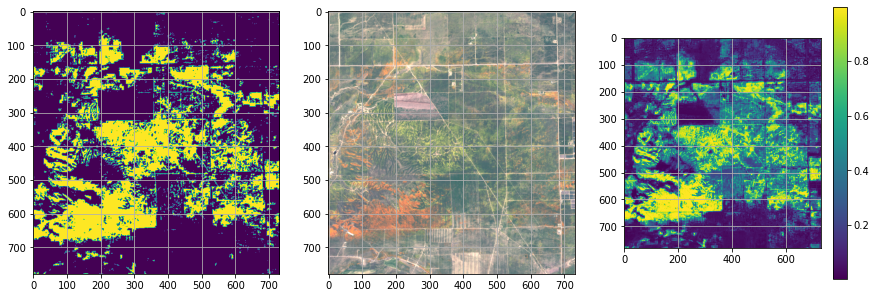

In [17]:
#antelope positive
antelope_pos_preds, antelope_pos_probas = predict_pixels_probas(antelope_pos, scaler)
visual_check(antelope_pos_preds, antelope_pos_probas, antelope_pos)

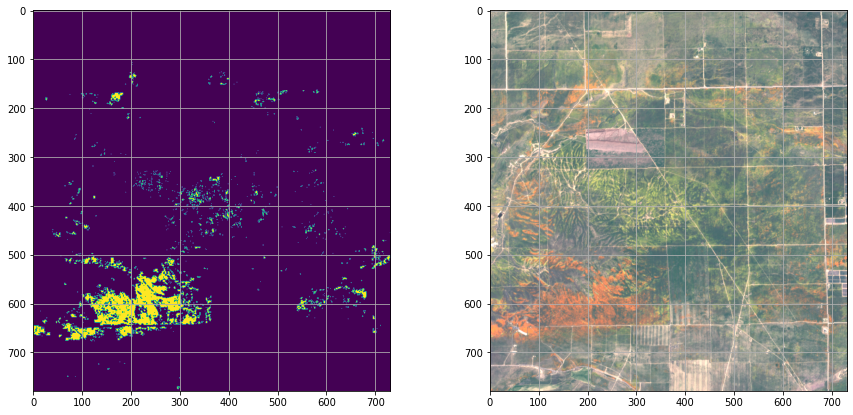

In [258]:
#look at thresholded probabilities
antelope_pospix = plot_thresh(antelope_pos_probas, 0.99, antelope_pos)

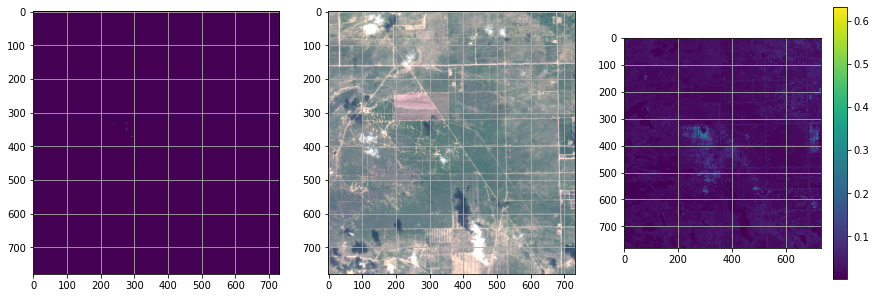

In [120]:
#antelope negative
antelope_neg_preds, antelope_neg_probas = predict_pixels_probas(antelope_neg, scaler)
visual_check(antelope_neg_preds, antelope_neg_probas, antelope_neg)

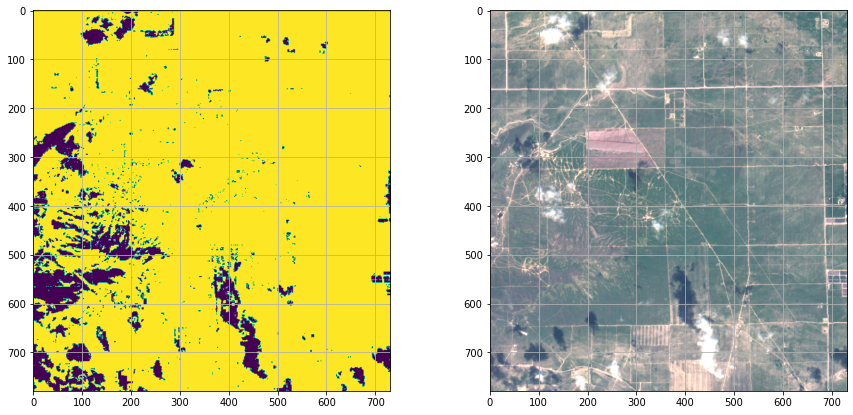

In [186]:
#look at thresholded probabilities
antelope_negpix = plot_thresh(antelope_neg_probas, 0.01, antelope_neg)

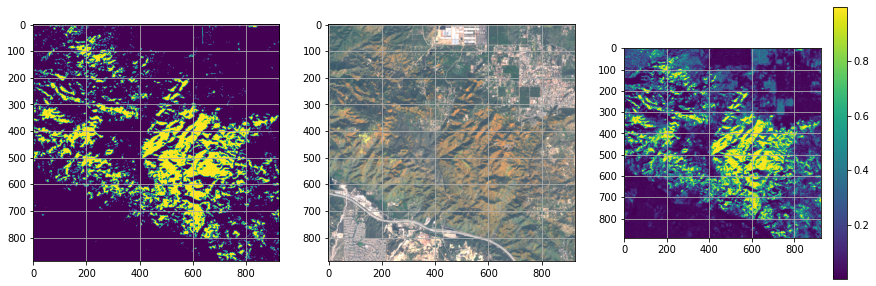

In [127]:
#elsinore positive
elsinore_pos_preds, elsinore_pos_probas = predict_pixels_probas(elsinore_pos, scaler)
visual_check(elsinore_pos_preds, elsinore_pos_probas, elsinore_pos)

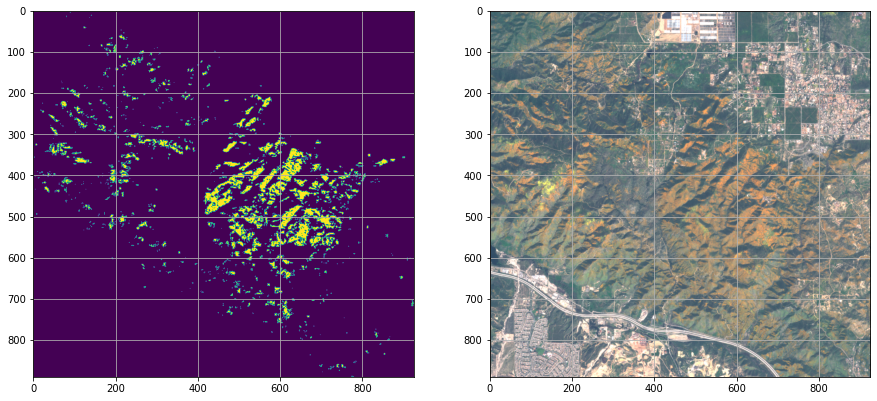

In [187]:
#look at thresholded probabilities
elsinore_pospix = plot_thresh(elsinore_pos_probas, 0.99, elsinore_pos)

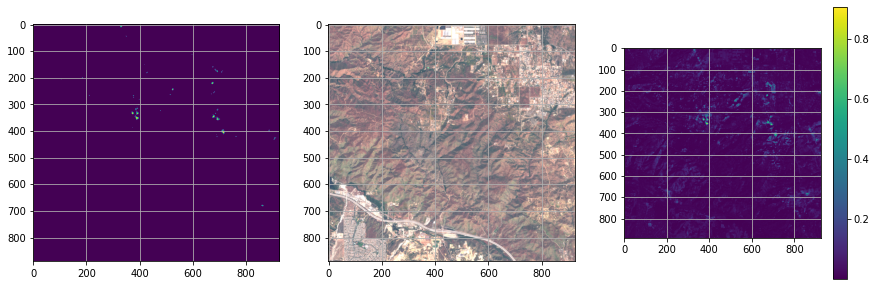

In [133]:
#elsinore negative
elsinore_neg_preds, elsinore_neg_probas = predict_pixels_probas(elsinore_neg, scaler)
visual_check(elsinore_neg_preds, elsinore_neg_probas, elsinore_neg)

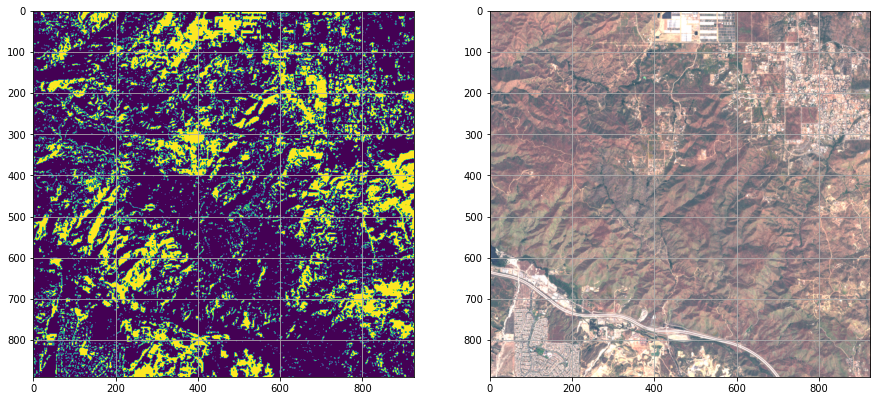

In [188]:
#look at thresholded probabilities
elsinore_negpix = plot_thresh(elsinore_neg_probas, 0.025, elsinore_neg)

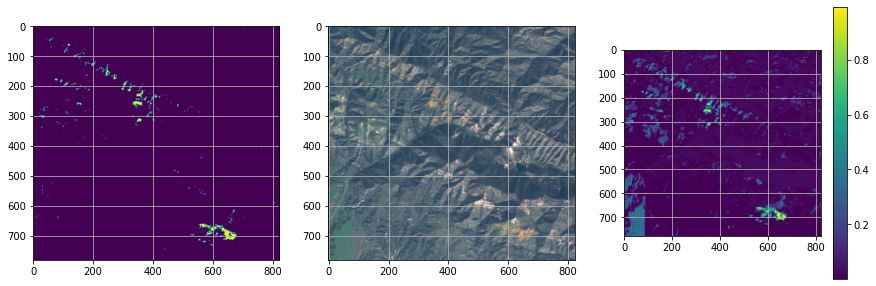

In [138]:
#grassmtn positive
grassmtn_pos_preds, grassmtn_pos_probas = predict_pixels_probas(grassmtn_pos, scaler)
visual_check(grassmtn_pos_preds, grassmtn_pos_probas, grassmtn_pos)

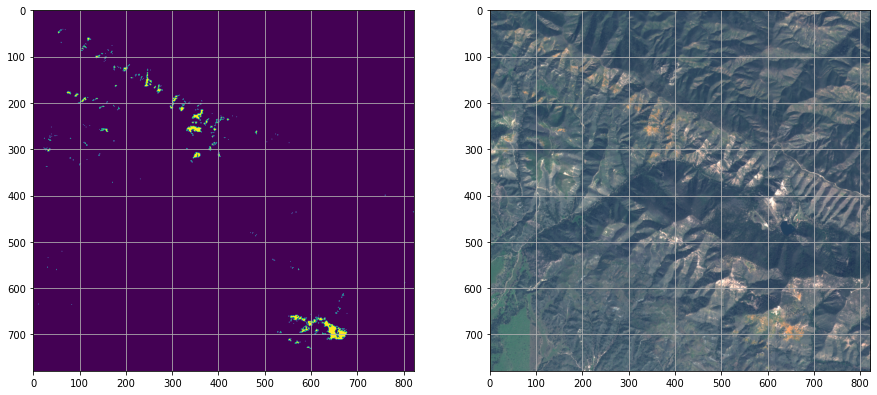

In [338]:
#look at thresholded probabilities
grassmtn_pospix = plot_thresh(grassmtn_pos_probas, 0.6, grassmtn_pos)

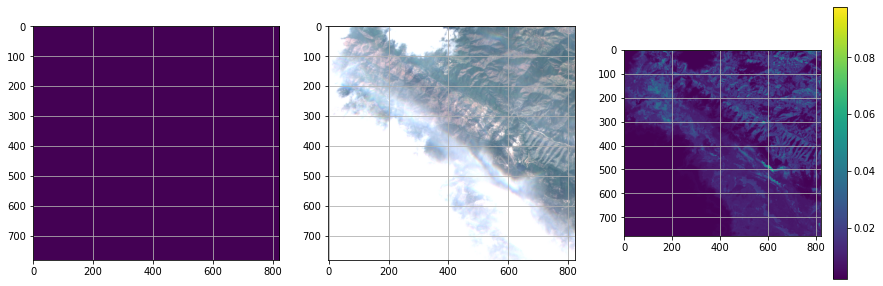

In [147]:
#grassmtn negative
grassmtn_neg_preds, grassmtn_neg_probas = predict_pixels_probas(grassmtn_neg, scaler)
visual_check(grassmtn_neg_preds, grassmtn_neg_probas, grassmtn_neg)

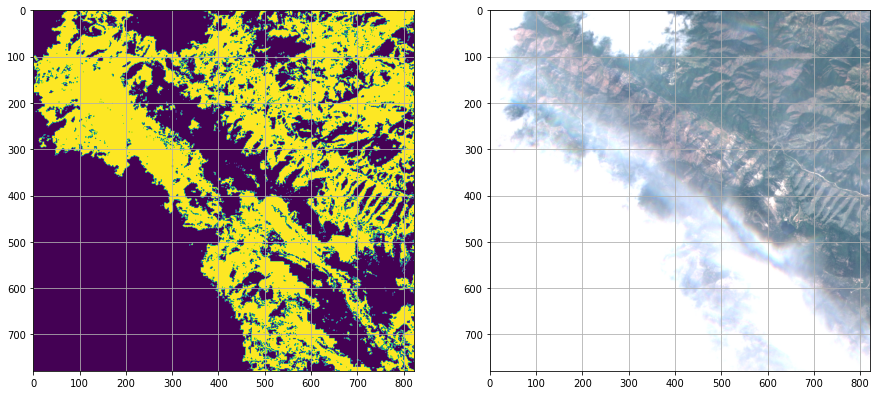

In [190]:
#look at thresholded probabilities
grassmtn_negpix = plot_thresh(grassmtn_neg_probas, 0.01, grassmtn_neg)

In [339]:
#convert poppy labeled pixel arrays to Boolean
antelope_pospix_iter1 = antelope_pospix == 1
elsinore_pospix_iter1 = elsinore_pospix == 1
grassmtn_pospix_iter1 = grassmtn_pospix == 1

#get number of pixels labelled as poppy
n_antelope = np.count_nonzero(antelope_pospix_iter1)
n_elsinore = np.count_nonzero(elsinore_pospix_iter1)
n_grassmtn = np.count_nonzero(grassmtn_pospix_iter1)

#generate Boolean array of randomly labelled pixels from no-poppy image
#get 3 times the number of positives
antelope_negpix_iter1 = get_neg(antelope_neg, n_antelope*3)
elsinore_negpix_iter1 = get_neg(elsinore_neg, n_elsinore*3)
grassmtn_negpix_iter1 = get_neg(grassmtn_neg, n_grassmtn*3)

#add pixel labels from this iteration to pixel labels from previous iteration(s)
#note: this is really important, model will not update properly if not

antelope_pospix_iter1 = np.logical_or(antelope_pospix_iter0, antelope_pospix_iter1)
elsinore_pospix_iter1 = np.logical_or(elsinore_pospix_iter0, elsinore_pospix_iter1)
grassmtn_pospix_iter1 = np.logical_or(grassmtn_pospix_iter0, grassmtn_pospix_iter1)

antelope_negpix_iter1 = np.logical_or(antelope_negpix_iter0, antelope_negpix_iter1)
elsinore_negpix_iter1 = np.logical_or(elsinore_negpix_iter0, elsinore_negpix_iter1)
grassmtn_negpix_iter1 = np.logical_or(grassmtn_negpix_iter0, grassmtn_negpix_iter1)

In [343]:
#save Boolean arrays
np.save('/home/esther/poppy-finder/data/antelope_pospix_iter1.npy', antelope_pospix_iter1)
np.save('/home/esther/poppy-finder/data/antelope_negpix_iter1.npy', antelope_negpix_iter1)
np.save('/home/esther/poppy-finder/data/elsinore_pospix_iter1.npy', elsinore_pospix_iter1)
np.save('/home/esther/poppy-finder/data/elsinore_negpix_iter1.npy', elsinore_negpix_iter1)
np.save('/home/esther/poppy-finder/data/grassmtn_pospix_iter1.npy', grassmtn_pospix_iter1)
np.save('/home/esther/poppy-finder/data/grassmtn_negpix_iter1.npy', grassmtn_negpix_iter1)

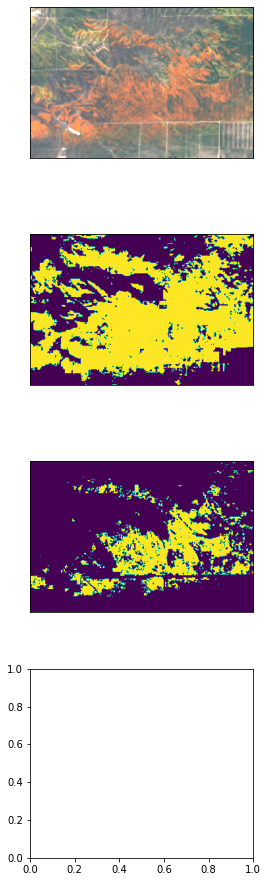

In [35]:
#for demo3

preds = antelope_pos_preds
probas = antelope_pos_probas
img = antelope_pos

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4,16))
    
axs[1].imshow(preds[470:700,0:340])
axs[0].imshow(np.minimum(img[470:700,0:340, [3,2,1]] * 5, 1))
#axs[2].imshow(probas[400:700,0:340])

#threshold prediction probabilities
probas_thresh = np.copy(probas)
thresh = 0.99
probas_thresh[probas_thresh < thresh] = 0
probas_thresh[probas_thresh >= thresh] = 1

axs[2].imshow(probas_thresh[470:700,0:340])

axs[0].set_xticks([])
axs[1].set_xticks([])
#axs[2].set_xticks([])
axs[2].set_xticks([])

axs[0].set_yticks([])
axs[1].set_yticks([])
#axs[2].set_yticks([])
axs[2].set_yticks([])

fs = 20
#axs[1].set_title('Predicted poppies', fontsize=fs)
#axs[2].set_title('Prediction probability', fontsize=fs)
#axs[2].set_title('Thresholded', fontsize=fs)